# Task 2: Clustering

Реализуйте distance and density based clustering Из лекции 5. Возьмите датасеты из http://cs.joensuu.fi/sipu/datasets/  (хотя бы 4 разных, среди которых как те, где больше трех измерений, так и те, где их только два. Для двумерных делайте визуализации) и покажите как работает на них данный метод (предположим, что мы точно знаем сколько должно быть кластеров), в качестве метрики считайте normalized_mutual_info_score из sklearn. Сделайте выводы на основе графиков расстояния/плотности о структуре данных/наличии выбросов и т.п. 3 бала

**Дополнительно**:

Исследуйте помогают ли методы определния количества кластеров из лекции для этих датасетов. 1 бал

Попробуйте найти методы получше для датасетов исходя из формы и описания датасетов. 1 бал + 1 бал за использование нестандартных методов (можно уточнить у преподавателя будет ли тот или иной фреймворк или метод засчитываться за "нестандартный")



=== Обрабатываем датасет R15 ===


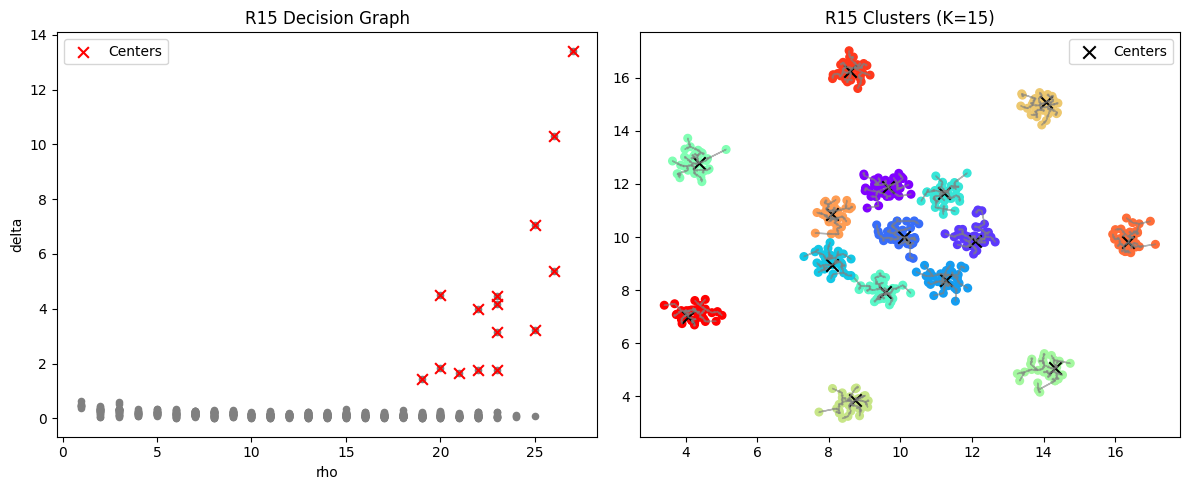

NMI для R15: 0.9914

=== Обрабатываем датасет Aggregation ===


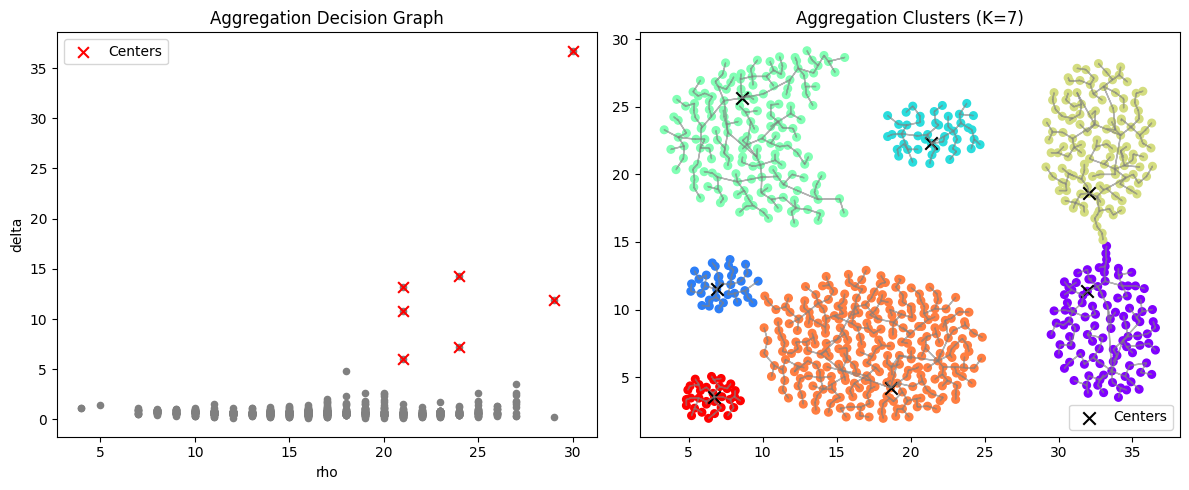

NMI для Aggregation: 0.9957

=== Обрабатываем датасет Dim032 ===
Dim032: 32D dataset
Предсказанные кластеры: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Размеры кластеров: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
NMI = 1.0
NMI для Dim032: 1.0000

=== Обрабатываем датасет Dim064 ===
Dim064: 64D dataset
Предсказанные кластеры: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Размеры кластеров: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
NMI = 1.0
NMI для Dim064: 1.0000

=== Обрабатываем датасет unbalance ===


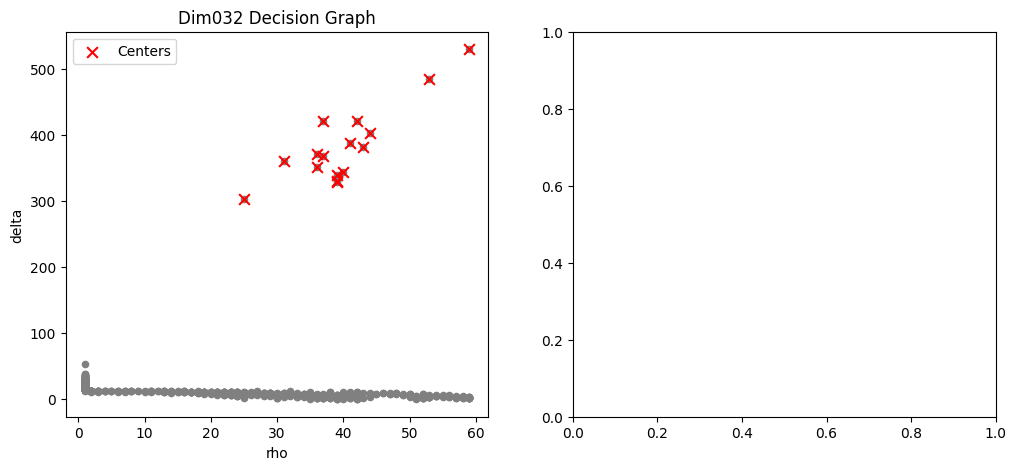

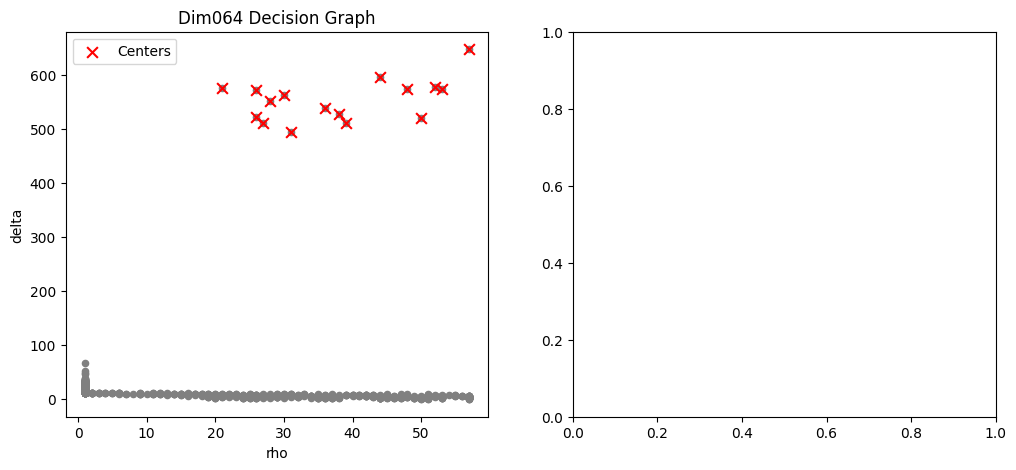

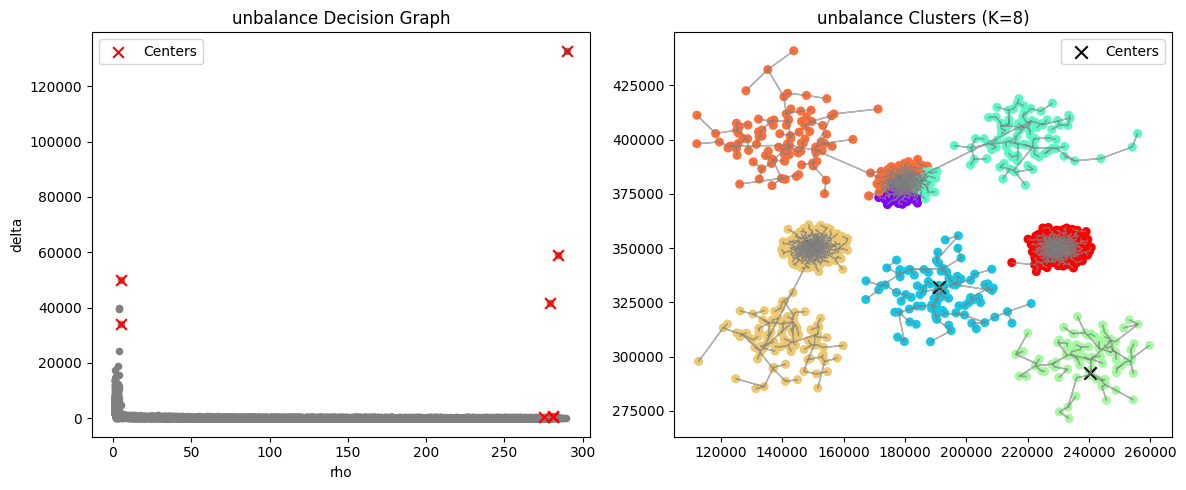

NMI для unbalance: 0.8366

=== Обрабатываем датасет s4 ===


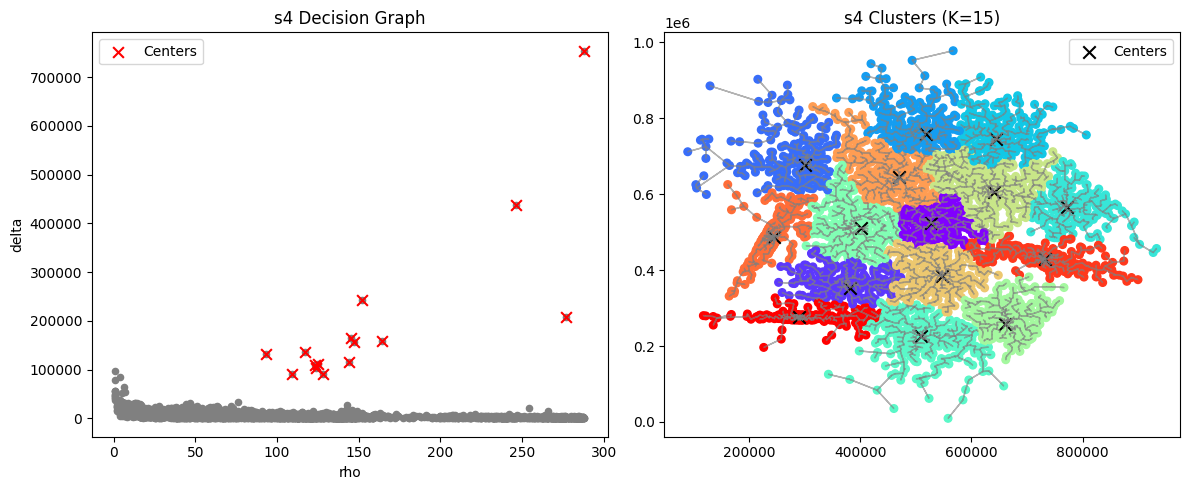

NMI для s4: 0.7234

=== Обрабатываем датасет leaves ===
leaves: 64D dataset
Предсказанные кластеры: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Размеры кластеров: [5, 14, 1, 1, 1, 1, 2, 6, 2, 37, 1, 4, 1, 4, 3, 9, 3, 1, 1, 1, 6, 36, 1, 3, 26, 1, 15, 1, 1, 13, 89, 4, 74, 1, 6, 2, 1, 2, 2, 1, 2, 1, 2, 4, 9, 1, 2, 1, 13, 38, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 132, 1, 1, 1, 1, 8, 5, 2, 8, 2, 1, 5, 19, 2, 58, 1, 9, 1, 2, 121, 1, 1, 1, 1, 36, 221, 1, 1, 1, 55, 7, 408, 9]
NMI = 0.5953671775467172
NMI для leaves: 0.5954


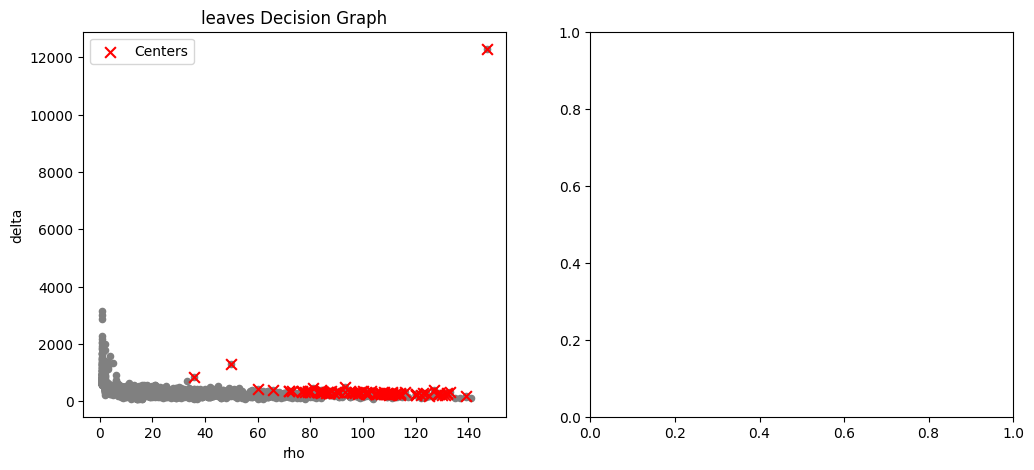

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import normalized_mutual_info_score


def load_dataset(file1, file2=None):
    """
    Загружает датасет. Если file2 передан, он содержит метки, иначе метки берутся из последней колонки file1.
    """
    X = np.loadtxt(file1)
    if file2:
        y = np.loadtxt(file2).astype(int) 
    elif X.shape[1] > 1:
        X, y = X[:, :-1], X[:, -1].astype(int)
    else:
        X, y = X, None 
    return X, y

def select_dc(distance_matrix, percent=2.0):
    """ Выбор d_c так, чтобы примерно percent% расстояний были меньше d_c """
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    return np.percentile(distances, percent)

def compute_rho(distance_matrix, dc):
    """ Плотность rho_i = число точек, чьё расстояние < dc """
    return np.sum(distance_matrix < dc, axis=1)

def compute_delta(distance_matrix, rho):
    """ Delta: расстояние до ближайшей точки с большей плотностью """
    n = len(rho)
    delta = np.zeros(n)
    sorted_indices = np.argsort(-rho)
    idx_max_rho = sorted_indices[0]
    delta[idx_max_rho] = np.max(distance_matrix[idx_max_rho])

    for i in range(1, n):
            idx = sorted_indices[i] 
            bigger = sorted_indices[:i]
            dist_to_higher = distance_matrix[idx, bigger]
            delta[idx] = np.min(dist_to_higher)
    return delta

def find_cluster_centers(rho, delta, num_clusters):
    """ Выбираем num_clusters центров по наибольшим значениям rho*delta """
    return np.argsort(rho * delta)[-num_clusters:]

def assign_clusters(distance_matrix, rho, centers):
    """ Назначение кластеров и построение "родительской" связи """
    n = len(rho)
    labels = np.full(n, -1, dtype=int)
    parent = np.full(n, -1, dtype=int)

    for cid, c in enumerate(centers):
        labels[c] = cid

    sorted_indices = np.argsort(-rho)
    for i in range(1, n):
        idx = sorted_indices[i]
        if labels[idx] == -1:
            bigger = sorted_indices[:i]
            if bigger.size > 0:
                j = bigger[np.argmin(distance_matrix[idx, bigger])]
                labels[idx] = labels[j]
                parent[idx] = j
    return labels, parent


def process_dataset(X, y_true=None, dc_percent=2.0, title="Dataset"):
    """
    X: координаты shape (n_samples, n_features)
    y_true: метки (или None)
    dc_percent: процент попарных расстояний для выбора dc
    title: название датасета для графиков
    """
    distance_matrix = squareform(pdist(X, metric='euclidean'))
    dc = select_dc(distance_matrix, percent=dc_percent)
    rho = compute_rho(distance_matrix, dc)
    delta = compute_delta(distance_matrix, rho)

    num_clusters = len(np.unique(y_true))
    centers = find_cluster_centers(rho, delta, num_clusters)
    clusters_pred, parents = assign_clusters(distance_matrix, rho, centers)

    nmi_value = normalized_mutual_info_score(y_true, clusters_pred) if y_true is not None else None

    # ====== Визуализация (только если 2D) ======
   
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    ax0 = axes[0]
    ax0.scatter(rho, delta, c='gray', s=20)
    ax0.scatter(rho[centers], delta[centers], c='red', s=60, marker='x', label='Centers')
    ax0.set_xlabel("rho")
    ax0.set_ylabel("delta")
    ax0.set_title(f"{title} Decision Graph")
    ax0.legend()
    if X.shape[1] == 2:
        ax1 = axes[1]
        scatter = ax1.scatter(X[:,0], X[:,1], c=clusters_pred, cmap='rainbow', s=30)
        ax1.scatter(X[centers,0], X[centers,1], c='black', s=80, marker='x', label='Centers')

        # Рисуем стрелки (от точки к её "родителю")
        for i in range(len(X)):
            j = parents[i]
            if j != -1:
                ax1.arrow(
                    X[i,0], X[i,1],
                    X[j,0] - X[i,0], 
                    X[j,1] - X[i,1],
                    length_includes_head=True,
                    head_width=0.05,
                    head_length=0.1,
                    fc='gray', ec='gray', alpha=0.6
                )

        ax1.set_title(f"{title} Clusters (K={num_clusters})")
        ax1.legend()
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"{title}: {X.shape[1]}D dataset")
        unique_clusters = np.unique(clusters_pred)
        print("Предсказанные кластеры:", unique_clusters)
        print("Размеры кластеров:", [np.sum(clusters_pred == uc) for uc in unique_clusters])
        if nmi_value is not None:
            print("NMI =", nmi_value)
    
    return clusters_pred, nmi_value


datasets = [
    {"name": "R15", "files": ("hw_4_data\R15.txt", None), "dc_percent": 2.0},
    {"name": "Aggregation", "files": ("hw_4_data\Aggregation.txt", None), "dc_percent": 2.0},
    {"name": "Dim032", "files": ("hw_4_data\dim032.txt", "hw_4_data\dim032.pa.txt"), "dc_percent": 2.0},
    {"name": "Dim064", "files": ("hw_4_data\dim064.txt", "hw_4_data\dim064.pa.txt"), "dc_percent": 2.0},
    {"name": "unbalance", "files": ("hw_4_data\\unbalance2.txt", "hw_4_data\\unbalance.pa.txt"), "dc_percent": 2.0},
    {"name": "s4", "files": ("hw_4_data\\s4.txt", "hw_4_data\\s4-label.pa"), "dc_percent": 2.0},
    {"name": "leaves", "files": ("hw_4_data\\leaves.txt", "hw_4_data\\leaves.pa"), "dc_percent": 2.0},
]

for ds in datasets:
    X, y = load_dataset(*ds["files"])
    print(f"\n=== Обрабатываем датасет {ds['name']} ===")
    _clusters, _nmi = process_dataset(X, y, dc_percent=ds["dc_percent"], title=ds["name"])
    if _nmi is not None:
        print(f"NMI для {ds['name']}: {_nmi:.4f}")
    else:
        print(f"Для {ds['name']} истинных меток нет, NMI не считается.")


На основе графиков делаем вывод что алгоритм очень хорошо отработал на выбранных датасетах:

На 2d датасетах с понятным разделением (R15, Aggregation) идеально, более того по decision граф видно что центры выделяются вполне однозначно

Также очень хорошо для датасета с большим перекрытием между кластерами(s4), центры также довольно однозначны

На 2d датасете с большим дисбалансом классов(Unbalance) отрабатывает не очень хорошо, и почти все центры выделяются не точно и на графике видно как они слабо отделяются от точек, как центры не выбранные

В простых датасетах с большим кол-вом измерений(dim32, dim64) отработало идеально

В сложном многомерном датасете (leaves) довольно плохо